In [3]:
import os 
from pathlib import Path 

if "notebooks" in os.getcwd():
    os.chdir("..")
%pwd


'/home/penguinsfly/Documents/playground/urban/uncertain-social-bandit'

In [4]:
import pandas as pd
import numpy as np
import xarray as xr
import numpy.random as npr
import copy

from tqdm import tqdm
from pathlib import Path

from itertools import product as iterprod

import socialbandit as sb

import matplotlib.pyplot as plt


In [21]:
def is_prevchoice_diff(A_prev, A_curr):
    # A_*: binary matrices of size "num_tasks x num_agents"
    return np.sum(A_prev * A_curr, axis=0) < 1.0

def get_task_choices(A):
    inds = np.where(A > 0)
    return inds[0][np.argsort(inds[1])]

def get_task_rewards(Y):
    return Y.sum(axis=0)

def aggregate_rewards(rewards, condition):
    # num = condition.sum(axis=0).mean()
    # mag = np.abs(rewards[condition]).mean() if num > 0 else 0.0
    num = np.mean(condition.sum(axis=0))
    mag = np.mean(np.abs(rewards[condition])) if num > 0 else 0.0
    return dict(num=num, mag=mag)

def calculate_entropy(X):
    _, n = np.unique(X, return_counts=True)
    P = n/sum(n)
    return np.sum(-P * np.log2(P))

why is paper using `as.matrix(rnorm(1,mean = EnvirionemntAdol[ind,]$Mean,sd=EnvirionemntAdol[ind,]$Variance))`

In [29]:
class SocialMAB_ChildDev(sb.models.SocialMultiArmedBandit):
    def __init__(self, num_agents=20, max_time=1200, social_alpha=0,
                 agg_explore_step=50, agg_reward_step=400):
        
        social_set_fn = None
        social_learner = None
        if social_alpha > 0:
            # in paper alpha = 0.8 but in code sometimes diminishingSocial = 0.77
            social_set_fn = 'all2all'
            social_learner = sb.learners.SocialMassPower(alpha = social_alpha)
        
        # in code EnvirionemntKids wasn't even used, and defined not like in paper (var_upp[paper] = 40, var_upp[code] = 10)
        # plus in code, var and std of environment got mixed up in many paces
        task_settings = sb.tasks.ChildDevelopmentEnvironment(
            env_levels = 12 
        )
        
        initializer = sb.initializers.InitializerBanditAgnostic(
            mu_fn = lambda x: 100.0, # in code, some places used 0.0, but paper said 100.0
            sigma2_fn = lambda x: 40.0 # in code s0^2 is sometimes 5.0 but paper said 40.0
        )
        
        # in code tau = 0.8 and tau = 1.0 mixed but in paper tau = 1.0
        action_sampler = sb.tasks.SoftmaxSampler(tau = 1.0)
        
        # in code sometimes it is var_error is Variance of task
        # but then sometimes it is either these constants: 360 or 3600
        belief_updater  = sb.beliefs.BayesianMeanTracker(var_error = 3600)
        
        super().__init__(
            task_settings   = task_settings,
            social_settings = sb.social.SocialSetting(N = num_agents, social_fn=social_set_fn),
            clock           = sb.utils.ExperimentClock(T = max_time),
            initializer     = initializer,
            action_sampler  = action_sampler,
            belief_updater  = belief_updater,
            action_learner  = sb.learners.MeanGreedyExploit(),
            social_learner  = social_learner
        )
        
        self.set_state_managers()
        
        analysis_size = (max_time+1, num_agents)
        
        self.analysis = dict(
            params = dict(
                agg_explore_step = agg_explore_step, 
                agg_reward_step = agg_reward_step
            ),
            per_agent = dict(
                explore = np.zeros(analysis_size),
                choice = np.zeros(analysis_size),
                reward = np.zeros(analysis_size)
            ),
            aggregate = dict(
                explore_num = [],
                unq_choices = [],
                explore_ent = [], 
                mean_reward = [],
                loss_num = [],
                loss_mag = [],
                gain_num = [],
                gain_mag = []                
            )
        )
        
    def analyze(self):
        t = self.t
        
        anly_per_agent = self.analysis['per_agent']
        anly_params = self.analysis['params']
        agg_anly = self.analysis['aggregate']
        
        anly_per_agent['explore'][t,:] = is_prevchoice_diff(self.states.A, self.prev_states.A)
        anly_per_agent['choice'][t,:] = get_task_choices(self.states.A)
        anly_per_agent['reward'][t,:] = get_task_rewards(self.states.Y)
        
        agg_explore_step = anly_params['agg_explore_step']
        if t % agg_explore_step == 1 and t > 1:
            agg_anly['explore_num'].append(
                np.mean(anly_per_agent['explore'][t-agg_explore_step:t,:].sum(axis=0))        
            )
            
            choice_matrix = anly_per_agent['choice'][t-agg_explore_step:t,:]
            agg_anly['explore_ent'].append(
                np.mean([calculate_entropy(X) for X in choice_matrix.T])                
            )
            
            agg_anly['unq_choices'].append(
                np.mean([len(np.unique(X)) for X in choice_matrix.T])     
            )
            
            
        agg_reward_step = anly_params['agg_reward_step']
        if t % agg_reward_step == 0 and t > 0:
            reward_matrix = anly_per_agent['reward'][t-agg_reward_step:t]
            agg_anly['mean_reward'].append(np.mean(reward_matrix))
            agg_loss = aggregate_rewards(reward_matrix, reward_matrix < 0)
            
            agg_anly['loss_num'].append(agg_loss['num'])
            agg_anly['loss_mag'].append(agg_loss['mag'])
            
            agg_gain = aggregate_rewards(reward_matrix, reward_matrix > 0)
            
            agg_anly['gain_num'].append(agg_gain['num'])
            agg_anly['gain_mag'].append(agg_gain['mag'])
            
        if t == self.clock.T:
            print(t)
            for k, v in agg_anly.items():
                agg_anly[k] = np.array(v)


In [17]:
model = SocialMAB_ChildDev(num_agents=20)
model.run()
model.analysis['aggregate']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 1970.67it/s]

1200


{'explore_num': array([49.5 , 49.75, 48.95, 47.1 , 47.9 , 47.2 , 45.1 , 46.3 , 38.15,
        29.4 , 34.55, 28.5 , 26.9 , 25.4 , 23.95, 23.8 , 24.2 , 29.1 ,
        27.  , 26.5 , 28.65, 28.1 , 27.4 ]),
 'unq_choices': array([36.  , 33.8 , 29.2 , 27.7 , 26.8 , 25.15, 22.6 , 20.55, 33.8 ,
        25.35, 26.75, 19.9 , 14.35, 11.8 ,  9.35,  7.9 ,  7.  ,  8.1 ,
         7.05,  6.95,  6.5 ,  6.7 ,  6.6 ]),
 'explore_ent': array([5.04684504, 4.92938276, 4.62630465, 4.452239  , 4.39964551,
        4.26681517, 4.0179738 , 3.86354529, 4.44130392, 3.44243441,
        3.79924562, 3.11740307, 2.4710492 , 2.24912744, 1.88131599,
        1.65611807, 1.62388851, 1.94214857, 1.70049615, 1.71007554,
        1.70796143, 1.77950983, 1.69819846]),
 'mean_reward': array([20.41467821, 70.4065505 , 97.09627742]),
 'loss_num': array([107.95,  64.4 ,  10.15]),
 'loss_mag': array([27.77732079, 66.0236723 , 40.78103476]),
 'gain_num': array([291.05, 335.6 , 389.85]),
 'gain_mag': array([ 38.35915844,  96.58684356

In [18]:
model = SocialMAB_ChildDev(num_agents=20,social_alpha = 0.8)
model.run()
model.analysis['aggregate']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 1734.23it/s]

1200


{'explore_num': array([49.65, 49.35, 48.65, 48.95, 48.95, 49.7 , 48.95, 49.55, 37.  ,
        25.55, 28.15, 41.35, 45.3 , 44.55, 42.65, 21.25,  1.2 ,  0.8 ,
         0.8 ,  1.3 ,  0.7 ,  0.9 ,  0.7 ]),
 'unq_choices': array([36.  , 33.45, 29.15, 24.6 , 24.25, 21.15, 18.05, 17.  , 32.4 ,
        22.2 , 19.55,  9.7 ,  8.65,  7.15,  8.2 ,  5.75,  1.35,  1.2 ,
         1.3 ,  1.35,  1.25,  1.2 ,  1.15]),
 'explore_ent': array([5.03395118, 4.88139532, 4.63407964, 4.13600298, 3.98822794,
        3.62217884, 3.28278863, 3.34757659, 4.31455461, 2.91248832,
        2.87906033, 1.94135257, 1.83324998, 1.61652985, 1.75547143,
        1.15684016, 0.08321356, 0.04636762, 0.05245782, 0.07898537,
        0.0454453 , 0.05165468, 0.0392956 ]),
 'mean_reward': array([22.27077461, 76.25584173, 99.90364461]),
 'loss_num': array([99.9 , 54.05,  0.35]),
 'loss_mag': array([27.95427315, 67.03144099, 39.17363854]),
 'gain_num': array([299.1 , 345.95, 399.65]),
 'gain_mag': array([ 39.12050061,  98.64253816, 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 2058.20it/s]


1200
(array([ 78, 115, 119, 121, 131, 133, 133, 134, 136, 136, 136, 138, 138,
       138, 139, 139, 139, 140, 141, 143]), array([15,  1, 16,  6, 11,  4,  5,  2,  3, 13, 18,  7,  8, 17,  0,  9, 10,
       12, 19, 14]))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 1820.34it/s]


1200
(array([ 19, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139,
       142, 142, 142, 142, 142, 142, 142]), array([ 8,  0,  3,  4,  7, 10, 11, 13, 14, 15, 16, 18, 19,  1,  2,  5,  6,
        9, 12, 17]))


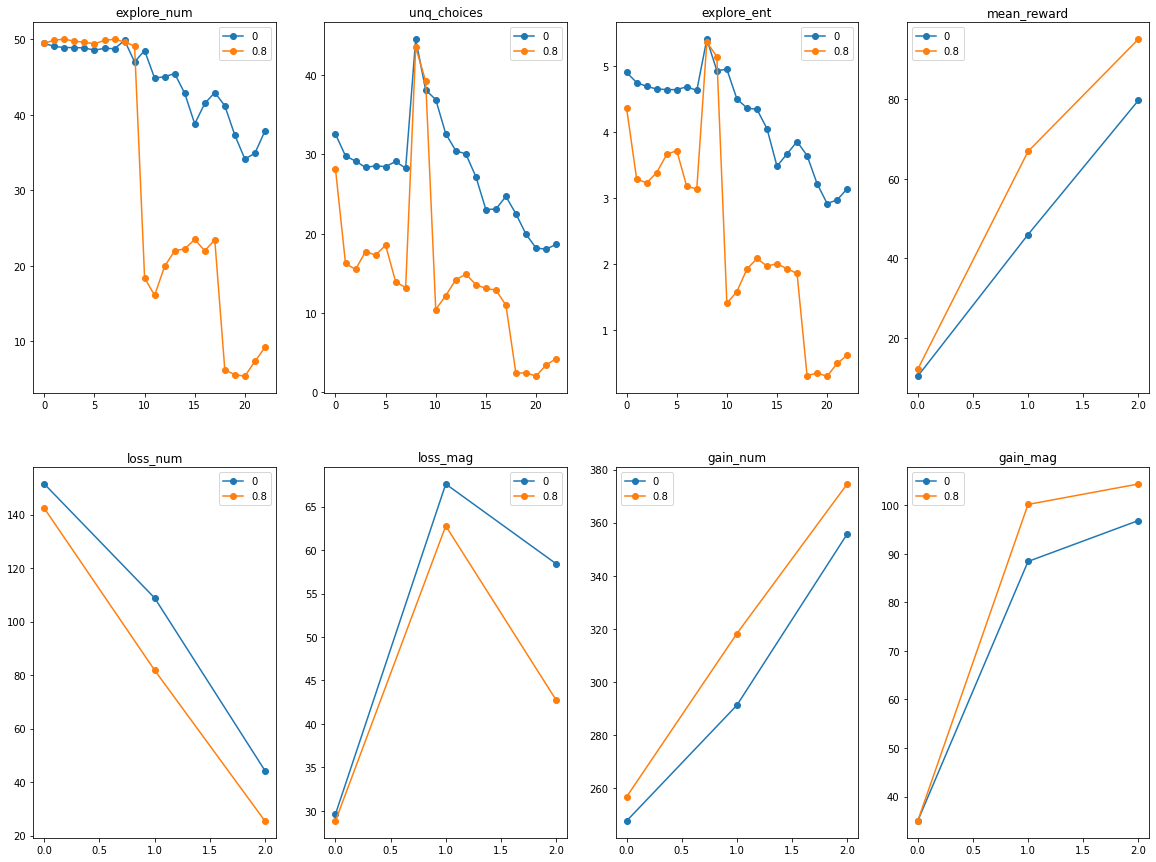

In [28]:
social_alphas = [0, 0.8]

plt.figure(figsize=(20,15))

for social_alpha in social_alphas:
    model = SocialMAB_ChildDev(num_agents=20, social_alpha = social_alpha)
    
    model.run()
    agg_anly = model.analysis['aggregate']
    
    for i,(k,v) in enumerate(agg_anly.items()): 
        plt.subplot(2,4,i+1)
        plt.plot(v, '-o', label=social_alpha)
        
        plt.title(k)
        plt.legend()

        